# Agglomerative clustering with prior orientation info

## Hierarchical tree

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import ward, fcluster, cut_tree, optimal_leaf_ordering, to_tree, ClusterNode
from collections import defaultdict

In [117]:
# Import Bedretto M0 experiment provisional dataset 
catalog = pd.read_csv('seiscomp-exp-dd_20240415.csv')
catalog_xyz = catalog[['x', 'y', 'z']]
X = catalog_xyz.to_numpy()

In [3]:
# import toy dataset with 3 planes, 2 orientations, 4k datapoints
toy = pd.read_csv('toy-2planes.csv')
X_toy = toy[['x', 'y', 'z']].values
clusters_toy = toy['cluster'].values

In [119]:
"""
Linkage matrix

Each row represents a step in the agglomerative algorithm

Column 0 (Z[i, 0]): Index of the first cluster (or observation) being merged.
Column 1 (Z[i, 1]): Index of the second cluster (or observation) being merged.
Column 2 (Z[i, 2]): Distance between the two clusters being merged.
Column 3 (Z[i, 3]): Number of original observations in the newly formed cluster.
"""
Z = ward(X)
Z

array([[5.63800000e+03, 7.64200000e+03, 1.76566201e-03, 2.00000000e+00],
       [4.34000000e+02, 4.51100000e+03, 4.29080526e-03, 2.00000000e+00],
       [2.67400000e+03, 6.96300000e+03, 5.02338526e-03, 2.00000000e+00],
       ...,
       [1.60190000e+04, 1.60200000e+04, 8.83758115e+02, 3.96600000e+03],
       [1.60180000e+04, 1.60210000e+04, 9.18382098e+02, 4.04700000e+03],
       [1.60220000e+04, 1.60230000e+04, 1.17747115e+03, 8.01300000e+03]])

In [132]:
roots, nodes = to_tree(Z, rd=True)

In [134]:
def get_leaves(node):
    """Return the leaf nodes for a given ClusterNode."""
    if node.is_leaf():
        return [node.id]
    else:
        return get_leaves(node.left) + get_leaves(node.right)

In [135]:
for node in nodes:
    get_leaves(node)

In [ ]:
# Initialize variables to track the maximum distance and corresponding cluster size
max_distance = 0
max_distance_size = 0

# Iterate through each row of Z
for row in Z:
    cluster1 = int(row[0])
    cluster2 = int(row[1])
    distance = row[2]
    new_cluster_size = row[3]

    # Check if the size of the new cluster is 5
    if new_cluster_size == 5:
        # Update max_distance if the current distance is greater
        if distance > max_distance:
            max_distance = distance
            max_distance_size = new_cluster_size

print(f"Maximum distance where cluster size is 5: {max_distance}")

Maximum distance where cluster size is 5: 13.656692953800068


In [120]:
clusters = []
cluster_ids = cut_tree(Z)
for label in np.unique(cluster_ids):
    cluster = X[cluster_ids.flatten() == label] #points
    clusters.append(cluster) 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8013 but corresponding boolean dimension is 64208169

In [98]:
len(X)

8013

In [121]:
# Define the threshold minimum count
n = 3

# Get the shape of the matrix
n_rows, n_cols =clusters.shape

# Initialize variables to track the first qualifying column
first_column_id = -1
num_unique_values = -1

# Loop through each column
for col_idx in range(n_cols):
    # Get the unique values and their counts for the current column
    unique_values, counts = np.unique(clusters[:, col_idx], return_counts=True)
    
    # Check if all unique values appear at least n times
    if np.all(counts >= n):
        first_column_id = col_idx
        num_unique_values = len(unique_values)
        break  # Stop checking further columns

# Print the result
if first_column_id != -1:
    print(f"First column where each unique value appears at least {n} times:")
    print(f"Column ID: {first_column_id}")
    print(f"Number of unique values in this column: {num_unique_values}")
else:
    print("No column found where each unique value appears at least {n} times.")

AttributeError: 'list' object has no attribute 'shape'

In [27]:
# Define the threshold minimum count
n = 4

# Get the shape of the matrix
n_rows, n_cols =  clusters.shape

# Initialize variables to track the first qualifying column
first_column_id = -1
num_unique_values = -1

# Loop through each column
for col_idx in range(n_cols):
    # Get the unique values and their counts for the current column
    unique_values, counts = np.unique(clusters[:, col_idx], return_counts=True)
    
    # Check if at least one unique value appears at least n times
    if np.any(counts >= n):
        first_column_id = col_idx
        num_unique_values = len(unique_values)
        break  # Stop checking further columns

# Print the result
if first_column_id != -1:
    print(f"First column where at least one unique value appears at least {n} times:")
    print(f"Column ID: {first_column_id}")
    print(f"Number of unique values in this column: {num_unique_values}")
else:
    print(f"No column found where at least one unique value appears at least {n} times.")

First column where at least one unique value appears at least 4 times:
Column ID: 189
Number of unique values in this column: 7824


In [38]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

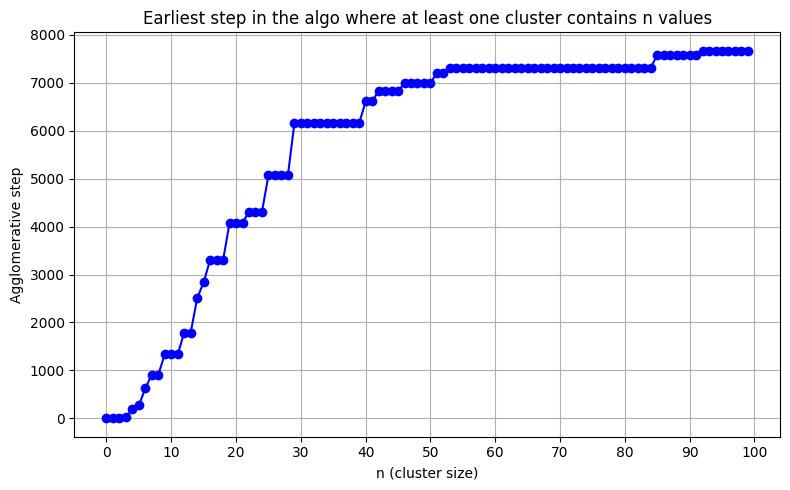

In [39]:
# Define range of n values to test
n_values = range(0, 100)  # Test n from 1 to 5

# Initialize lists to store results
column_ids = []
for n in n_values:
    # Initialize variables to track the first qualifying column
    first_column_id = -1

    # Loop through each column
    for col_idx in range(clusters.shape[1]):
        # Get the unique values and their counts for the current column
        unique_values, counts = np.unique(clusters[:, col_idx], return_counts=True)

        # Check if at least one unique value appears at least n times
        if np.any(counts >= n):
            first_column_id = col_idx
            break  # Stop checking further columns

    # Append the result for the current n
    column_ids.append(first_column_id)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(n_values, column_ids, marker='o', linestyle='-', color='b')
plt.title('Earliest step in the algo where at least one cluster contains n values')
plt.xlabel('n (cluster size)')
plt.ylabel('Agglomerative step')
plt.xticks(n_values)
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.grid(True)
plt.tight_layout()
plt.show()

In [54]:
def find_indices(subset, X):
    """
    Find the indices of the subset points in the original dataset X.
    
    Parameters:
    subset (ndarray): The subset of points to find in X.
    X (ndarray): The original dataset.
    
    Returns:
    list: A list of indices where the points in subset are located in X.
    """
    indices = []
    for point in subset:
        index = np.where((X == point).all(axis=1))[0]
        if index.size > 0:
            indices.append(index[0])
    return indices


In [62]:
import random

In [65]:
def plane_fit(data, normal_vect, eps):
    # Normalize the normal vector
    #normal_vect = normal_vect / np.linalg.norm(normal_vect)

    # Project points onto the plane defined by the normal vector
    projections = np.dot(data, normal_vect)

    # Compute distances from each point to the plane (absolute values)
    distances = np.abs(projections)

    # Check if all distances are within the tolerance epsilon
    return np.all(distances <= eps)


In [103]:
def compute_bounding_box_dimensions(points):
    """
    Compute the dimensions (length, width, height) of a bounding box of a 3D dataset.

    Parameters:
    points (ndarray): An array of shape (N, 3) representing N points in 3D space.

    Returns:
    tuple: A tuple (length, width, height) where
           - length is the size along the X axis
           - width is the size along the Y axis
           - height is the size along the Z axis
    """
    # Ensure points is a numpy array
    points = np.asarray(points)

    # Compute min and max along each axis
    min_point = np.min(points, axis=0)
    max_point = np.max(points, axis=0)

    # Compute dimensions
    length = max_point[0] - min_point[0]
    width = max_point[1] - min_point[1]
    height = max_point[2] - min_point[2]

    return length, width, height

In [167]:
def agg(X, normal_vect):

    marked_ids = []
    
    # linkage matrix
    Z = ward(X)

    # iterate over the number of clusters at each step of the agglomerative algorithm: i = n,n-1,...,1
    #for i in range(len(X), 0, -1):
    for i in range(5500, 0, -1):

        marked_ids_step = []
        clusters = []

        # Get clusters from stage i
        cluster_ids = cut_tree(Z, n_clusters=i) #ids
        for label in range(i):
            cluster = X[cluster_ids.flatten() == label] #points
            clusters.append(cluster)    

        print(f"Agglomerative step {len(X)-i}:")

        # iterate over clusters at this step
        for k in range(i):

            # check if cluster has enough points to fit plane
            if len(clusters[k]) >= 3:

                #check if orientation2 fits
                length, width, height = compute_bounding_box_dimensions(clusters[k])
                eps = min(length, width, height)

                if plane_fit(clusters[k], normal_vect, eps) :

                    # mark ids of points in cluster 
                    #cluster_id = np.unique(cluster_ids)[k]
                    #marked_ids.append(cluster_id)
                    indices = find_indices(clusters[k], X)
                    marked_ids_step.append(indices)
                    print(f"Cluster {k} fits orientation. {len(indices)} points: {indices}")

                else:
                    marked_ids_step.append([])
            
            else:
                marked_ids_step.append([])
                
        
        marked_ids.append(marked_ids_step)
        #print(f"Marked ids contains {len(marked_ids_step)} clusters.")

    return marked_ids

In [67]:
normal_vect = np.array([ 0.64268971, -0.76592777,  0.01745241]) # strike = 220, dip = 89

In [107]:
marked_ids = agg(X, normal_vect) #eps = max(length, width, height)

Agglomerative step 0:
Agglomerative step 1:
Agglomerative step 2:
Agglomerative step 3:
Agglomerative step 4:
Agglomerative step 5:
Agglomerative step 6:
Agglomerative step 7:
Agglomerative step 8:
Agglomerative step 9:
Agglomerative step 10:
Agglomerative step 11:
Agglomerative step 12:
Agglomerative step 13:
Agglomerative step 14:
Agglomerative step 15:
Agglomerative step 16:
Agglomerative step 17:
Agglomerative step 18:
Agglomerative step 19:
Agglomerative step 20:
Agglomerative step 21:
Agglomerative step 22:
Agglomerative step 23:
Agglomerative step 24:
Agglomerative step 25:
Agglomerative step 26:
Agglomerative step 27:
Agglomerative step 28:
Agglomerative step 29:
Agglomerative step 30:
Agglomerative step 31:
Agglomerative step 32:
Agglomerative step 33:
Agglomerative step 34:
Agglomerative step 35:
Agglomerative step 36:
Agglomerative step 37:
Agglomerative step 38:
Agglomerative step 39:
Agglomerative step 40:
Agglomerative step 41:
Agglomerative step 42:
Agglomerative step 43

In [111]:
marked_ids_v2 = agg(X, normal_vect) #eps = min(length, width, height)/2

Agglomerative step 0:
Agglomerative step 1:
Agglomerative step 2:
Agglomerative step 3:
Agglomerative step 4:
Agglomerative step 5:
Agglomerative step 6:
Agglomerative step 7:
Agglomerative step 8:
Agglomerative step 9:
Agglomerative step 10:
Agglomerative step 11:
Agglomerative step 12:
Agglomerative step 13:
Agglomerative step 14:
Agglomerative step 15:
Agglomerative step 16:
Agglomerative step 17:
Agglomerative step 18:
Agglomerative step 19:
Agglomerative step 20:
Agglomerative step 21:
Agglomerative step 22:
Agglomerative step 23:
Agglomerative step 24:
Agglomerative step 25:
Agglomerative step 26:
Agglomerative step 27:
Agglomerative step 28:
Agglomerative step 29:
Agglomerative step 30:
Agglomerative step 31:
Agglomerative step 32:
Agglomerative step 33:
Agglomerative step 34:
Agglomerative step 35:
Agglomerative step 36:
Agglomerative step 37:
Agglomerative step 38:
Agglomerative step 39:
Agglomerative step 40:
Agglomerative step 41:
Agglomerative step 42:
Agglomerative step 43

In [168]:
normal_vect = np.array([ 0.4066747 , -0.91340632,  0.01745241])  # strike = 204, dip = 89
marked_ids_v3 = agg(X, normal_vect) #eps = min(length, width, height)

Agglomerative step 2513:
Agglomerative step 2514:
Agglomerative step 2515:
Agglomerative step 2516:
Agglomerative step 2517:
Agglomerative step 2518:
Agglomerative step 2519:
Agglomerative step 2520:
Agglomerative step 2521:
Agglomerative step 2522:
Agglomerative step 2523:
Agglomerative step 2524:
Agglomerative step 2525:
Agglomerative step 2526:
Agglomerative step 2527:
Agglomerative step 2528:
Agglomerative step 2529:
Agglomerative step 2530:
Agglomerative step 2531:
Agglomerative step 2532:
Agglomerative step 2533:
Agglomerative step 2534:
Agglomerative step 2535:
Agglomerative step 2536:
Agglomerative step 2537:
Agglomerative step 2538:
Agglomerative step 2539:
Agglomerative step 2540:
Agglomerative step 2541:
Agglomerative step 2542:
Agglomerative step 2543:
Agglomerative step 2544:
Agglomerative step 2545:
Agglomerative step 2546:
Agglomerative step 2547:
Agglomerative step 2548:
Agglomerative step 2549:
Agglomerative step 2550:
Agglomerative step 2551:
Agglomerative step 2552:


In [194]:
def remove_empty_lists(input_list):
    if isinstance(input_list, list):
        return [remove_empty_lists(item) for item in input_list if item != []]
    return input_list

In [212]:
def is_empty_array(arr):
    return isinstance(arr, np.ndarray) and arr.size == 0

def remove_empty_arrays(input_list):
    if isinstance(input_list, list):
        return [remove_empty_arrays(item) for item in input_list if not is_empty_array(item) and (not isinstance(item, list) or item)]
    return input_list



In [220]:
# remove empty arrays at each step of algo
full_marked_ids = [remove_empty_arrays(arr) for arr in marked_ids_v3 if not is_empty_array(arr)]

# remove empty lists (steps without clusters)
vfull_marked_ids = [sublist for sublist in full_marked_ids if sublist]

In [225]:
vfull_marked_ids[1]

[[2165, 2484, 3048]]

In [179]:
def clean_clusters(cluster_lists):
    """ 
    Remove empty lists and duplicate clusters from marked_clusters

    """

    # Create a dictionary to track the last occurrence of each cluster
    last_occurrence = {}
    for i, clusters in enumerate(non_empty_clusters):
        for cluster in clusters:
            last_occurrence[tuple(cluster)] = i

    # Function to check if one cluster is a subset of another with exactly one more point
    def is_subset_with_one_more(cluster1, cluster2):
        set1, set2 = set(cluster1), set(cluster2)
        return set1 < set2 and len(set2) == len(set1) + 1

    # Remove duplicates, keeping only the last occurrence
    cleaned_clusters = [[] for _ in non_empty_clusters]
    for cluster, last_index in last_occurrence.items():
        cleaned_clusters[last_index].append(list(cluster))

    # Apply subset condition
    for i in range(len(cleaned_clusters) - 1):
        next_clusters = cleaned_clusters[i + 1]
        current_clusters = cleaned_clusters[i]
        to_remove = []
        for current_cluster in current_clusters:
            for next_cluster in next_clusters:
                if is_subset_with_one_more(current_cluster, next_cluster):
                    to_remove.append(current_cluster)
                    break
        cleaned_clusters[i] = [cluster for cluster in current_clusters if cluster not in to_remove]

    return cleaned_clusters

In [226]:
# remove duplicates and (hyper)subset clusters
clean_marked_ids = clean_clusters(vfull_marked_ids)

In [230]:
# remove again empty lists
vclean_marked_ids = [sublist for sublist in clean_marked_ids if sublist]

In [235]:
vclean_marked_ids

[[[282, 3583, 7922, 7979]],
 [[2013, 2119, 2343]],
 [[2165, 2484, 3048]],
 [[1487, 1493, 1752, 2015, 2165, 2442, 2484, 3048]],
 [[1828, 2247, 2676, 5108]],
 [[1548, 1993, 2567, 3062, 4698, 4817, 4936, 6340, 6861]],
 [[3164, 4855, 4896, 5547], [3417, 3587, 4572, 4755, 4761]],
 [[282, 3284, 3583, 4663, 7922, 7946, 7979]],
 [[1487, 1493, 1752, 2015, 2165, 2442, 2480, 2484, 3048]],
 [[1612, 1658, 1762, 2201, 2975, 3618, 3722, 5327, 7296]],
 [[1487, 1493, 1752, 2015, 2067, 2165, 2251, 2442, 2480, 2484, 3048]],
 [[4750, 4860, 5724]],
 [[282, 1215, 3284, 3583, 4065, 4663, 7922, 7946, 7979]],
 [[1548, 1993, 2567, 3062, 3607, 4698, 4817, 4936, 6340, 6861]],
 [[1756, 1828, 1928, 2196, 2247, 2510, 2676, 4759, 5108, 6904]],
 [[2599, 3254, 4120, 4129, 4537, 6811],
  [3164, 3417, 3587, 4572, 4755, 4761, 4855, 4896, 5547]],
 [[3742, 5148, 5167]],
 [[1929, 1979, 2200, 2378, 2574, 2609, 2713, 2729, 4525]],
 [[1471, 1740, 2578, 2810, 2911, 3795, 6426, 6927]],
 [[4787, 6150, 6488]],
 [[1738, 7839, 7866, 

In [260]:
total = 0
for i in range(len(vclean_marked_ids)):
    nums = []
    for k in range(len(vclean_marked_ids[i])):
        nums.append(len(vclean_marked_ids[i][k]))
    print(f"{i}. {len(vclean_marked_ids[i])} clusters with {nums} points")

    total += len(vclean_marked_ids[i])

print(f"total number of clusters: {total}")

0. 1 clusters with [4] points
1. 1 clusters with [3] points
2. 1 clusters with [3] points
3. 1 clusters with [8] points
4. 1 clusters with [4] points
5. 1 clusters with [9] points
6. 2 clusters with [4, 5] points
7. 1 clusters with [7] points
8. 1 clusters with [9] points
9. 1 clusters with [9] points
10. 1 clusters with [11] points
11. 1 clusters with [3] points
12. 1 clusters with [9] points
13. 1 clusters with [10] points
14. 1 clusters with [10] points
15. 2 clusters with [6, 9] points
16. 1 clusters with [3] points
17. 1 clusters with [9] points
18. 1 clusters with [8] points
19. 1 clusters with [3] points
20. 1 clusters with [4] points
21. 1 clusters with [4] points
22. 1 clusters with [15] points
23. 1 clusters with [15] points
24. 1 clusters with [9] points
25. 1 clusters with [5] points
26. 1 clusters with [9] points
27. 1 clusters with [8] points
28. 1 clusters with [36] points
29. 1 clusters with [12] points
30. 1 clusters with [21] points
31. 1 clusters with [5] points
32. 

In [348]:
def all_clusters(cluster_lists):
    
    all_clusters = []

    # fill the all_clusters list (with unique clusters)
    for i in range(len(cluster_lists)):
        for k in range(len(cluster_lists[i])):
            all_clusters.append(cluster_lists[i][k])  

    return all_clusters

In [349]:
all_cluster_ids = all_clusters(vclean_marked_ids)

In [329]:

def find_union_indices(cluster_lists):
    union_indices = []
    subset_indices = []
    
    # Iterate over each list except the last one
    for i in range(1, len(cluster_lists)):
        prev_list = cluster_lists[i - 1]
        current_list = cluster_lists[i]
        
        # Create a set of tuples of all pairs of clusters in prev_list
        cluster_pairs = list(combinations(prev_list, 2))
        
        # Iterate over each cluster in current_list
        for k in range(len(current_list)):
            current_cluster = set(current_list[k])
            
            # Check if current_cluster is the union of any pair in cluster_pairs
            for idx, (cluster1, cluster2) in enumerate(cluster_pairs):
                if current_cluster == set(cluster1) | set(cluster2):
                    # Add (i, k) to union_indices
                    union_indices.append((i, k))
                    
                    # Add (i-1, index of cluster1 and cluster2 in prev_list) to subset_indices
                    subset_indices.append((i-1, prev_list.index(cluster1), prev_list.index(cluster2)))
                    
                    break  # Stop checking further pairs for this current_cluster
    
    return union_indices, subset_indices

In [332]:
unions, subsets = find_union_indices(vclean_marked_ids)

In [333]:
unions

[(89, 1), (95, 1), (96, 0)]

In [334]:
subsets

[(88, 0, 1), (94, 0, 1), (95, 0, 1)]

In [335]:
def filter_clusters(cluster_lists, union_indices):
    filtered_clusters = []
    
    # Convert union_indices to a set of tuples for fast lookup
    union_set = set(union_indices)
    
    # Iterate over each list and each cluster within each list
    for i, clusters in enumerate(cluster_lists):
        for k, cluster in enumerate(clusters):
            # Check if (i, k) is not in union_indices
            if (i, k) not in union_set:
                filtered_clusters.append(cluster)
    
    return filtered_clusters

In [336]:
filtered_ids = filter_clusters(vclean_marked_ids, unions)

In [366]:
filtered_ids[0]

[282, 3583, 7922, 7979]

In [371]:
def retrieve_clusters(cluster_lists, X):
    retrieved_clusters = []

    # Iterate over each list of clusters
    for i in range(len(cluster_lists)):
        
        C=[]
        for cluster_indices in filtered_ids[i]:
            C.append(X[cluster_indices])

        retrieved_clusters.append(C)

    return retrieved_clusters

In [372]:
filtered_clusters = retrieve_clusters(filtered_ids, X)

In [374]:
filtered_clusters[1]

[array([ -79.5517218 ,  -37.55201927, -114.7908721 ]),
 array([ -79.75679262,  -37.43956188, -115.1865415 ]),
 array([ -80.0460004 ,  -37.81137475, -115.0290694 ])]

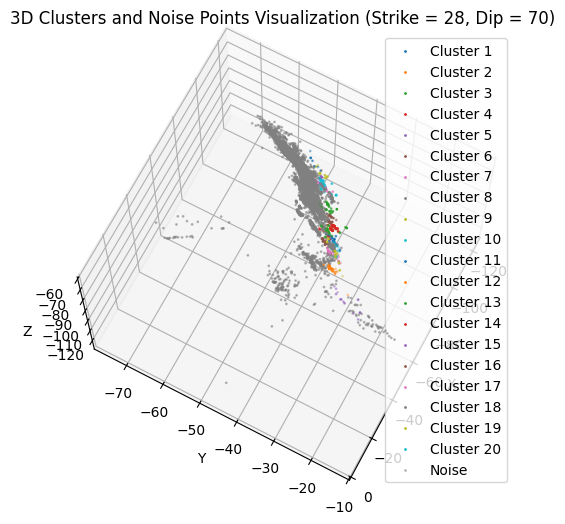

In [427]:
# Strike and dip angles (in degrees)
strike =28 # Example strike angle
dip = 70     # Example dip angle

# Create a figure and axis with 3D projection
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Rotate the view to match strike and dip
ax.view_init(elev=dip, azim=strike)

# Plot clusters
for i, cluster in enumerate(filtered_clusters[50:70]):
    cluster_X = np.array(cluster)
    ax.scatter(cluster_X[:, 0], cluster_X[:, 1], cluster_X[:, 2], label=f'Cluster {i+1}', s=1)

# Plot noise points (points not in any cluster)
all_points = np.array(X)
for cluster in filtered_clusters[50:70]:
    all_points = np.array([point for point in all_points if point not in np.array(cluster)])
if len(all_points) > 0:
    ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2], color='gray', alpha=0.5, label='Noise', s=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Clusters and Noise Points Visualization (Strike = {strike}, Dip = {dip})')
ax.legend()

plt.show()

## Version 2

In [399]:
def best_fit_plane(points):
    """
    Find the best-fit plane for a set of 3D points using PCA.
    
    """
    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)
    
    # Center the points by subtracting the centroid
    centered_points = points - centroid
    
    # Perform SVD on the centered points
    _, _, vh = np.linalg.svd(centered_points)
    
    # The normal vector of the best-fit plane is the third singular vector
    normal_vector = vh[2, :]
    
    return centroid, normal_vector

def point_to_plane_distances(points, centroid, normal_vector):
    """
    Calculate the distances from the points to the best-fit plane.

    """
    # Calculate the distances from each point to the plane
    distances = np.abs(np.dot(points - centroid, normal_vector)) / np.linalg.norm(normal_vector)
    
    # Calculate min, avg, and max distances
    min_distance = np.min(distances)
    avg_distance = np.mean(distances)
    max_distance = np.max(distances)
    
    return distances, min_distance, avg_distance, max_distance

In [417]:
def normal_vector_to_strike_dip(normal_vector):
    """
    Calculate the strike and dip of a plane from its normal vector.
    
    Parameters:
    normal_vector (numpy array): Normal vector to the plane.
    
    Returns:
    strike (float): Strike angle in degrees.
    dip (float): Dip angle in degrees.
    """
    # Normalize the normal vector
    normal_vector = normal_vector / np.linalg.norm(normal_vector)
    
    # Dip angle (arccosine of the z-component of the normal vector)
    dip = np.degrees(np.arccos(normal_vector[2]))
    
    # Strike angle (arctangent of the y-component and x-component of the normal vector)
    strike = np.degrees(np.arctan2(normal_vector[1], normal_vector[0]))
    
    # Ensure the strike is in the range [0, 360)
    if strike < 0:
        strike += 360
    
    return strike, dip

In [421]:
def agg_2(X, strike_min, strike_max, dip_min, dip_max):

    marked_ids = []
    
    # linkage matrix
    Z = ward(X)

    # iterate over the number of clusters at each step of the agglomerative algorithm: i = n,n-1,...,1
    #for i in range(len(X), 0, -1):
    for i in range(5500, 0, -1):

        marked_ids_step = []
        clusters = []

        # Get clusters from stage i
        cluster_ids = cut_tree(Z, n_clusters=i) #ids
        for label in range(i):
            cluster = X[cluster_ids.flatten() == label] #points
            clusters.append(cluster)    

        print(f"Agglomerative step {len(X)-i}:")

        # iterate over clusters at this step
        for k in range(i):

            # check if cluster has enough points to fit plane
            if len(clusters[k]) >= 10:

                #check if orientation2 fits
                #if k<5:
                    #eps=0
                #else:
                    #centroid , normal_vector = best_fit_plane(clusters[k])
                    #_, _, eps, _ = point_to_plane_distances(clusters[k], centroid, normal_vector) #average dis from best-fit plane

                _, normal_vector = best_fit_plane(clusters[k])
                strike, dip = normal_vector_to_strike_dip(normal_vector)

                #fit_check = []
                #for normal in normal_list:
                    #fit_check = plane_fit(clusters[k], normal, eps)

                #if any(fit_check):
                if (strike_min <= strike <= strike_max) and (dip_min <= dip <= dip_max): 
                    indices = find_indices(clusters[k], X)
                    marked_ids_step.append(indices)
                    print(f"Cluster {k} fits orientation. {len(indices)} points: {indices}")

                else:
                    marked_ids_step.append([])
            
            else:
                marked_ids_step.append([])
                
        
        marked_ids.append(marked_ids_step)
        #print(f"Marked ids contains {len(marked_ids_step)} clusters.")

    return marked_ids

In [422]:
marked_ids_v4 = agg_2(X, strike_min=204, strike_max=220, dip_min=80, dip_max=90) 

Agglomerative step 2513:
Agglomerative step 2514:
Agglomerative step 2515:
Agglomerative step 2516:
Agglomerative step 2517:
Agglomerative step 2518:
Agglomerative step 2519:
Agglomerative step 2520:
Agglomerative step 2521:
Agglomerative step 2522:
Agglomerative step 2523:
Agglomerative step 2524:
Agglomerative step 2525:
Agglomerative step 2526:
Agglomerative step 2527:
Agglomerative step 2528:
Agglomerative step 2529:
Agglomerative step 2530:
Agglomerative step 2531:
Agglomerative step 2532:
Agglomerative step 2533:
Agglomerative step 2534:
Agglomerative step 2535:
Agglomerative step 2536:
Agglomerative step 2537:
Agglomerative step 2538:
Agglomerative step 2539:
Agglomerative step 2540:
Agglomerative step 2541:
Agglomerative step 2542:
Agglomerative step 2543:
Agglomerative step 2544:
Agglomerative step 2545:
Agglomerative step 2546:
Agglomerative step 2547:
Agglomerative step 2548:
Agglomerative step 2549:
Agglomerative step 2550:
Agglomerative step 2551:
Agglomerative step 2552:


In [423]:
# remove empty arrays at each step of algo
full_marked_ids_4 = [remove_empty_arrays(arr) for arr in marked_ids_v4 if not is_empty_array(arr)]

# remove empty lists (steps without clusters)
vfull_marked_ids_4 = [sublist for sublist in full_marked_ids_4 if sublist]

# remove duplicates and (hyper)subset clusters
clean_marked_ids_4 = clean_clusters(vfull_marked_ids_4)

# remove again empty lists
vclean_marked_ids_4 = [sublist for sublist in clean_marked_ids_4 if sublist]

all_cluster_ids_4 = all_clusters(vclean_marked_ids_4)

unions_4, subsets_4 = find_union_indices(vclean_marked_ids_4)

filtered_ids_4 = filter_clusters(vclean_marked_ids_4, unions_4)

filtered_clusters_4 = retrieve_clusters(filtered_ids_4, X)


In [424]:
len(filtered_clusters_4)

4

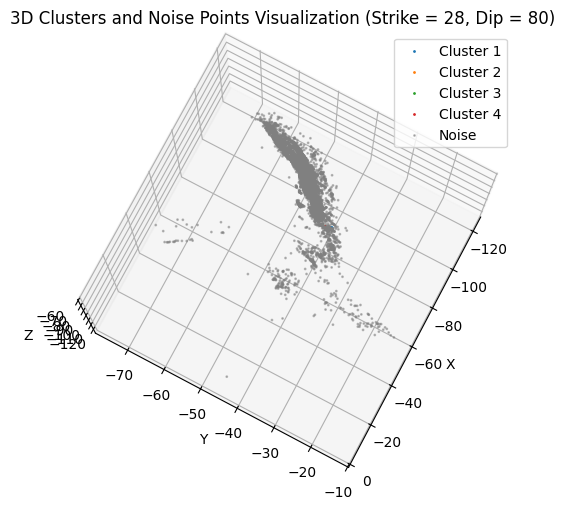

In [426]:
# Strike and dip angles (in degrees)
strike =28 # Example strike angle
dip = 80     # Example dip angle

# Create a figure and axis with 3D projection
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Rotate the view to match strike and dip
ax.view_init(elev=dip, azim=strike)

# Plot clusters
for i, cluster in enumerate(filtered_clusters_4):
    cluster_X = np.array(cluster)
    ax.scatter(cluster_X[:, 0], cluster_X[:, 1], cluster_X[:, 2], label=f'Cluster {i+1}', s=1)

# Plot noise points (points not in any cluster)
all_points = np.array(X)
for cluster in filtered_clusters_4:
    all_points = np.array([point for point in all_points if point not in np.array(cluster)])
if len(all_points) > 0:
    ax.scatter(all_points[:, 0], all_points[:, 1], all_points[:, 2], color='gray', alpha=0.5, label='Noise', s=1)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'3D Clusters and Noise Points Visualization (Strike = {strike}, Dip = {dip})')
ax.legend()

plt.show()

## Tree representation

In [137]:
# Function to find all leaf nodes under a given node
def get_leaves(node):
    if node.is_leaf():
        return [node.id]
    else:
        return get_leaves(node.left) + get_leaves(node.right)

# Find the root node of the subtree containing the subset
def find_subtree_root(node, leaf_ids):
    if node.is_leaf():
        return node
    else:
        left_leaves = get_leaves(node.left)
        right_leaves = get_leaves(node.right)
        if all(leaf in left_leaves for leaf in leaf_ids):
            return find_subtree_root(node.left, leaf_ids)
        elif all(leaf in right_leaves for leaf in leaf_ids):
            return find_subtree_root(node.right, leaf_ids)
        else:
            raise ValueError("Subset not found in the given subtree")

In [138]:
def get_marked_nodes(X,marked_ids):

    marked_nodes = []

    Z = ward(X)

    # Convert the linkage matrix to a tree of ClusterNode objects
    root, nodes = to_tree(Z, rd=True)

    for i in range(len(marked_ids)):

        marked = []

        for j in range(len(marked_ids[i])):
    
            # Find the leaf nodes corresponding to the subset
            leaf_ids = set()
            for index in marked_ids[i][j]:
                leaf_ids.add(index)

            # Find the root node of the subtree containing the subset
            subtree_root = find_subtree_root(root, marked_ids)
            marked.append(subtree_root)

        marked_nodes.append(marked)

    return marked_nodes